In [1]:
import sys
print(sys.path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


['d:\\Conda\\envs\\bitenv\\python39.zip', 'd:\\Conda\\envs\\bitenv\\DLLs', 'd:\\Conda\\envs\\bitenv\\lib', 'd:\\Conda\\envs\\bitenv', '', 'd:\\Conda\\envs\\bitenv\\lib\\site-packages', 'd:\\Conda\\envs\\bitenv\\lib\\site-packages\\win32', 'd:\\Conda\\envs\\bitenv\\lib\\site-packages\\win32\\lib', 'd:\\Conda\\envs\\bitenv\\lib\\site-packages\\Pythonwin']


In [2]:
#from binance.client import Client
#import time
#from datetime import datetime
#client = Client()

In [3]:
def validate_start_date(start_str):
    """Проверяет, что дата введена в правильном формате."""
    try:
        datetime.strptime(start_str, "%d %b, %Y")
        return True
    except ValueError:
        return False

def get_historical_klines(symbol, interval, start_str):
    """Загрузка всех свечей с Binance без API-ключа"""
    
    # Проверяем корректность формата даты
    if not validate_start_date(start_str):
        raise ValueError("Неверный формат даты! Используйте, например: '1 Jan, 2023'.")

    # Конвертируем дату в миллисекунды (требуется Binance API)
    start_timestamp = int(pd.Timestamp(start_str).timestamp() * 1000)

    data = []
    while True:
        candles = client.get_klines(symbol=symbol, interval=interval, startTime=start_timestamp, limit=1000)
        if not candles:
            break
        data.extend(candles)
        start_timestamp = candles[-1][0] + 1  # Обновляем стартовое время (добавляем 1 мс, чтобы избежать дубликатов)
        time.sleep(1)  # Пауза во избежание бана

    return pd.DataFrame(data, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "trades", "taker_base_vol",
        "taker_quote_vol", "ignore"
    ])

In [4]:
# Дата начала торгов BTC/USDT на Binance
#btc_start_date = "17 Sep, 2017"

# Загружаем **часовые свечи** BTC/USDT с момента первых торгов на Binance
#btc_data = get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, btc_start_date)

# Преобразуем временную метку в дату
#btc_data["timestamp"] = pd.to_datetime(btc_data["timestamp"], unit="ms")
#btc_data.set_index("timestamp", inplace=True)

# Сохраняем в CSV
#btc_data.to_csv("btc_1hour_data_from_2017.csv")
print("Данные сохранены!")

Данные сохранены!


In [5]:
btc_data=pd.read_csv('btc_1hour_data_from_2017.csv',parse_dates=['timestamp'])
btc_data.head()
print(btc_data.dtypes)  # Проверим типы данных
print(btc_data.head())   # Посмотрим первые строки

timestamp             datetime64[ns]
open                         float64
high                         float64
low                          float64
close                        float64
volume                       float64
close_time                     int64
quote_asset_volume           float64
trades                         int64
taker_base_vol               float64
taker_quote_vol              float64
ignore                         int64
dtype: object
            timestamp     open     high      low    close     volume  \
0 2017-09-17 00:00:00  3685.23  3709.94  3636.07  3670.00  20.731369   
1 2017-09-17 01:00:00  3670.00  3670.00  3601.00  3602.00  26.230265   
2 2017-09-17 02:00:00  3602.00  3650.00  3601.05  3640.02  29.225806   
3 2017-09-17 03:00:00  3641.01  3649.67  3580.00  3580.00  49.770159   
4 2017-09-17 04:00:00  3568.07  3604.79  3550.00  3560.01  15.203704   

      close_time  quote_asset_volume  trades  taker_base_vol  taker_quote_vol  \
0  1505609999999        7607

<Figure size 1000x500 with 0 Axes>

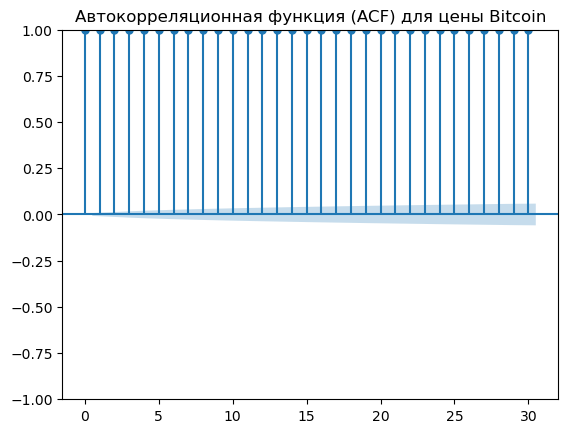

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
btc_prices = btc_data["close"].astype(float)    
plt.figure(figsize=(10, 5))
plot_acf(btc_prices, lags=30)
plt.title("Автокорреляционная функция (ACF) для цены Bitcoin")
plt.show()

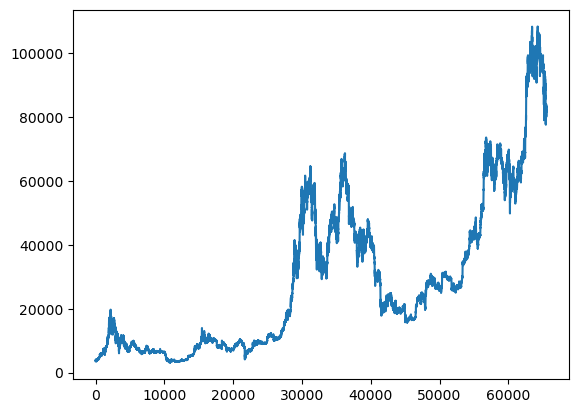

In [7]:
btc_dates=btc_data.index
plt.plot(btc_dates,btc_prices)

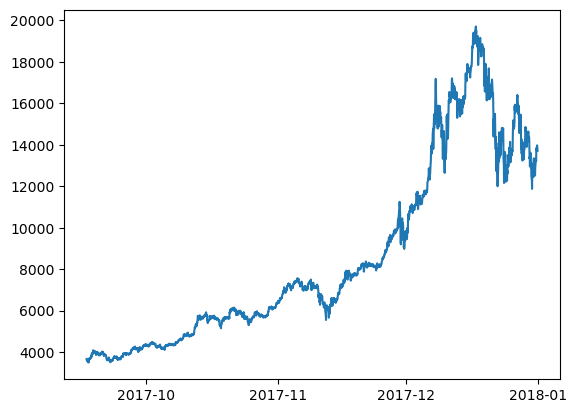

In [8]:
import matplotlib.dates as mdates
btc2017=btc_data.loc[btc_data['timestamp']<='2017-12-31 23:59:59']
btc_dates=btc2017['timestamp']
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Отображаем ГОД-МЕСЯЦ
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.plot(btc_dates,btc2017['close'])

In [58]:
from sklearn.preprocessing import MinMaxScaler
print(btc_data.columns)
mdataset=pd.concat([btc_data['timestamp'],btc_data['close']],axis=1)
finaldataset=pd.concat([btc_data['timestamp'],btc_data['close']],axis=1)
print(mdataset.head())


Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'trades', 'taker_base_vol', 'taker_quote_vol',
       'ignore'],
      dtype='object')
            timestamp    close
0 2017-09-17 00:00:00  3670.00
1 2017-09-17 01:00:00  3602.00
2 2017-09-17 02:00:00  3640.02
3 2017-09-17 03:00:00  3580.00
4 2017-09-17 04:00:00  3560.01


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

del finaldataset['timestamp']
finaldataset = scaler.fit_transform(finaldataset.values.reshape(-1,1))
finaldataset.shape

(65526, 1)

In [12]:
finaldataset

array([[0.00473571],
       [0.004089  ],
       [0.00445059],
       ...,
       [0.75103606],
       [0.75004822],
       [0.75051508]])

In [13]:
print(finaldataset.shape)
X_train, X_test = finaldataset[0:int(finaldataset.shape[0]*0.8):], finaldataset[int(finaldataset.shape[0]*0.8)::]
print("train_data: ", X_train.shape)
print("test_data: ", X_test.shape)

(65526, 1)
train_data:  (52420, 1)
test_data:  (13106, 1)


In [14]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 15
X_train, y_train = create_dataset(X_train, time_step)
X_test, y_test = create_dataset(X_test, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (52404, 15)
y_train:  (52404,)
X_test:  (13090, 15)
y_test (13090,)


In [16]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (52404, 15, 1)
X_test:  (13090, 15, 1)


In [17]:
print(np.__version__)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

1.26.4


In [18]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [19]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
1638/1638 [==============================] - 9s 4ms/step - loss: 4.9660e-04 - val_loss: 7.6588e-05
Epoch 2/200
1638/1638 [==============================] - 6s 3ms/step - loss: 1.2719e-05 - val_loss: 4.3926e-05
Epoch 3/200
1638/1638 [==============================] - 6s 3ms/step - loss: 1.1835e-05 - val_loss: 4.9920e-05
Epoch 4/200
1638/1638 [==============================] - 6s 3ms/step - loss: 1.0981e-05 - val_loss: 4.3371e-05
Epoch 5/200
1638/1638 [==============================] - 6s 3ms/step - loss: 9.5224e-06 - val_loss: 2.7872e-05
Epoch 6/200
1638/1638 [==============================] - 6s 3ms/step - loss: 8.5188e-06 - val_loss: 4.0341e-05
Epoch 7/200
1638/1638 [==============================] - 6s 3ms/step - loss: 7.7359e-06 - val_loss: 1.1407e-04
Epoch 8/200
1638/1638 [==============================] - 6s 3ms/step - loss: 6.8095e-06 - val_loss: 6.3083e-05
Epoch 9/200
1638/1638 [==============================] - 6s 4ms/step - loss: 6.4127e-06 - val_loss: 4.3343e-05
E

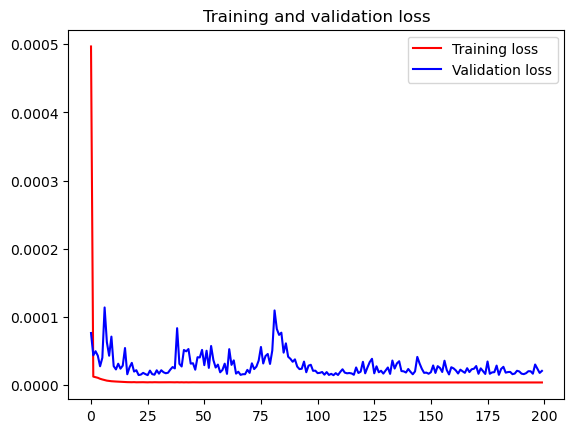

<Figure size 640x480 with 0 Axes>

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [22]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

410/410 [==============================] - 1s 1ms/step


((52404, 1), (13090, 1))

In [23]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [25]:
import math

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

In [29]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  203.88948836132687
Train data MSE:  41570.92346424364
Train data MAE:  102.20513405893846
-------------------------------------------------------------------------------------
Test data RMSE:  482.9706528870753
Test data MSE:  233260.6515501678
Test data MAE:  310.16151601890755


In [31]:
from itertools import cycle

In [34]:
import plotly.express as px

In [49]:
print(mdataset.head())
mdataset= mdataset[int(finaldataset.shape[0]*0.8)::]
print(mdataset.shape)

            timestamp    close
0 2017-09-17 00:00:00  3670.00
1 2017-09-17 01:00:00  3602.00
2 2017-09-17 02:00:00  3640.02
3 2017-09-17 03:00:00  3580.00
4 2017-09-17 04:00:00  3560.01
(13106, 2)


In [57]:
print(mdataset['timestamp'].shape)

(13106,)


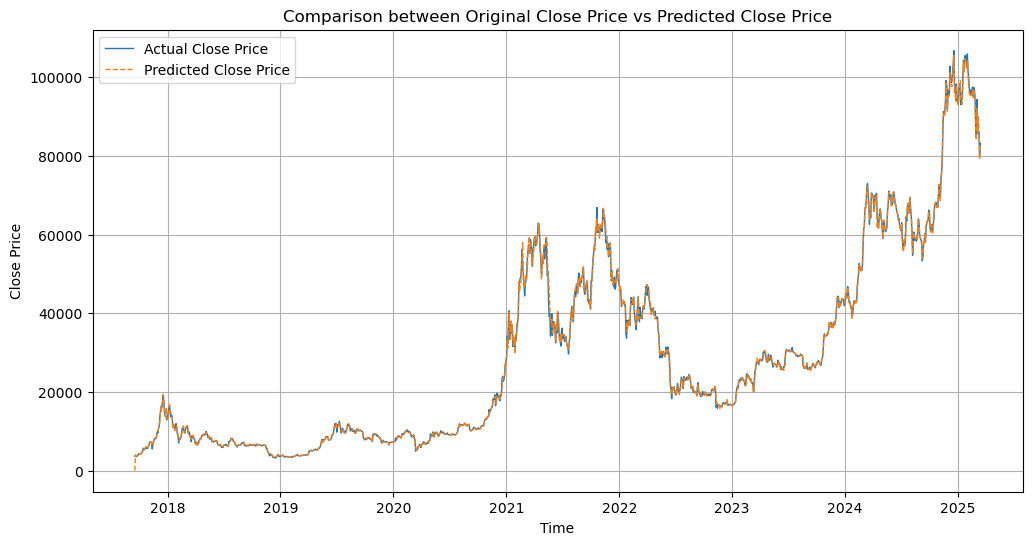

In [82]:
zeros=np.zeros(32)
realpredict=np.append(zeros,train_predict)
realpredict=np.append(realpredict,test_predict)
N=50
plt.figure(figsize=(12, 6))
plt.plot(mdataset['timestamp'][::N], mdataset['close'][::N], label="Actual Close Price", linestyle='-', linewidth=1)
plt.plot(mdataset['timestamp'][::N], realpredict[::N], label="Predicted Close Price", linestyle='--', linewidth=1)

# Добавление заголовка и подписей осей
plt.title("Comparison between Original Close Price vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)

In [79]:
lega=[(x,y) for x,y in zip (mdataset['close'],realpredict)] #realpredict
print(lega[30:40])

[(3950.01, 0.0), (3950.32, 0.0), (3950.32, 3634.125244140625), (3906.0, 3626.794189453125), (3931.23, 3682.88916015625), (3929.33, 3678.361083984375), (4040.01, 3701.90966796875), (4090.0, 3708.83154296875), (3988.01, 3684.3134765625), (4030.33, 3710.19775390625)]


In [59]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(finaldataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(finaldataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(finaldataset)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': mdataset['timestamp'],
                       'original_close': mdataset['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (65526, 2)
Test predicted data:  (65526, 2)


ValueError: array length 131052 does not match index length 65526

In [63]:
print(len(trainPredictPlot.reshape(1,-1)[0].tolist()))
print(len(testPredictPlot.reshape(1,-1)[0].tolist()))
print(train_predict)

131052
131052
[[ 3634.1252]
 [ 3626.7942]
 [ 3682.8892]
 ...
 [26495.852 ]
 [26596.115 ]
 [26603.605 ]]


In [83]:
model.save("model.h5")